# MusicAI
## Sztuczna Inteligencja - projekt
### Część 3 - konwolucyjna sieć neuronowa
Autorzy: Jakub Ochnik, Adam Karabiniewicz, Marcel Bieniek
___

Importing necessary libraries and packages

In [3]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sn

Constants

In [4]:
DATA_PATH = "Data\\data_full.json"

Loading dataset

In [5]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

Plot history

In [6]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

Splitting dataset into train, test and validation datasets

In [7]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets to match the shape CNN expects (last axis is like channel in color images)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

Building neural network model

In [8]:
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

Checking predicted output

In [9]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print(f"Target: {y}, Predicted label: {predicted_index}")


Plotting confusion matrix of predicted and actual results

In [18]:
def plot_conf_matrix(model, X_test):
    predictions = model.predict(X_test)
    #predictions[i] = predicted_index
    pred_argmax = []

    for i in range(len(predictions)):
        predicted_index = np.argmax(predictions[i])
        pred_argmax.append(predicted_index)

    conf_matrix = tf.math.confusion_matrix(labels=y_test, predictions=pred_argmax)
    print(conf_matrix)

    cat = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
    fig, ax = plt.subplots(figsize=(12,10), facecolor='white')
    #sn.heatmap(conf_matrix, annot=True, fmt='', xticklabels=cat, yticklabels=cat, cmap='Blues')
    sn.heatmap(conf_matrix/np.sum(conf_matrix, axis=1), annot=True, fmt='.2%', xticklabels=cat, yticklabels=cat, cmap='Blues')
    ax.set(xlabel="Predicted labels", ylabel="Actual labels")

    print(np.sum(conf_matrix, axis=1))

Main

In [10]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

In [11]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 32)         4

In [12]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30
188/188 [==============================] - 6s 28ms/step - loss: 2.3308 - accuracy: 0.2550 - val_loss: 1.8711 - val_accuracy: 0.3253

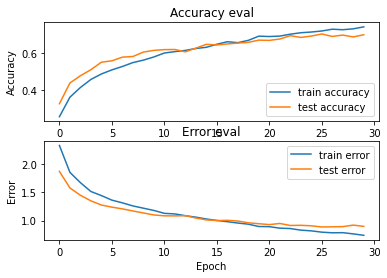

In [13]:
# plot accuracy/error for training and validation
plot_history(history)

In [14]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

79/79 - 1s - loss: 0.8666 - accuracy: 0.7027
Test accuracy: 0.7026810646057129


In [15]:
# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)

Target: 7, Predicted label: [7]


tf.Tensor(
[[151   1  35   6   0  10  21   0   2   8]
 [  0 212  12   0   0   8   0   0   0   4]
 [ 12   2 188   8   0   3   1   2   4  19]
 [  6   0  17 139   9   0  11  11  17  33]
 [ 11   0   3  11 152   0  18   9  35   8]
 [  5  16  24   2   0 223   0   0   2   7]
 [  1   0   4   2   3   1 228   0   2  21]
 [  0   1  19   7  17   4   0 197   5   7]
 [  5   0  19  17  26   3   4  13 154   9]
 [  9   2  51  25   1  10  18   7  17 112]], shape=(10, 10), dtype=int32)
[234 236 239 243 247 279 262 257 250 252]
(2499, 130, 13, 1)


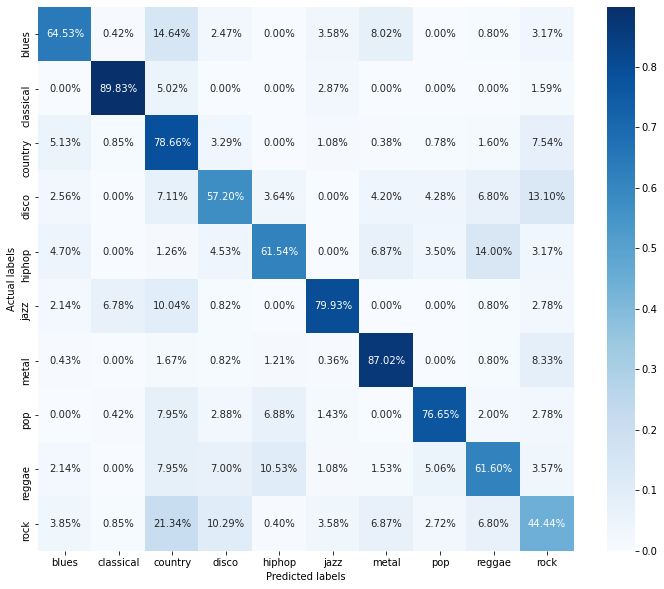

In [22]:
# plotting confusion matrix
plot_conf_matrix(model, X_test)